In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import svm
from pandas.tseries.offsets import MonthEnd
%matplotlib inline

In [3]:
%run -i financial_sector_functions.py

/home/luke/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
def return_function(df):
    if type(df)!=pd.DataFrame:
        df = pd.DataFrame(df)
    out_df = (df.shift(-1)-df)/df
    return out_df

In [8]:
data = pd.read_csv("financial_sector_clean_return_space_Dec_13.csv")
data.index = pd.DatetimeIndex(data.iloc[:,[0]].values.flatten())
data = data.iloc[:,1:]

sp500 = pd.read_csv('/home/luke/workspace/Sector-Analysis/data/CFRM521_final_project/SPX500.csv')
sp500.index = pd.DatetimeIndex(sp500.iloc[:,[0]].values.flatten())
sp500 = sp500.iloc[:,[1]]
sp500 = return_function(sp500)
sector_return = data.iloc[:,[0]]
x_data = data.iloc[:,1:]
sector_return,x_data = model_data(sector_return,x_data)
sector_return,sp500 = model_data(sector_return,sp500)

sector_beat_benchmark = pd.DataFrame((sector_return.values > sp500.values)*1,index = sector_return.index,columns = ['IFY beat benchmark'])

In [28]:
result_df = pd.DataFrame()
for gamma_value in map(lambda x: 10**(float(x)),np.arange(-3,4)):
    for c in np.linspace(0.1,10,20):
        svc_model = svm.SVC(C=c,gamma=gamma_value)
        svc_model.fit(x_data, sector_beat_benchmark)
        result_df.loc[gamma_value,c]=(svc_model.score(X=x_data,y=sector_beat_benchmark))

In [36]:
def svc_fit_function(x,y,nunmber_of_years_lookback,month_forecast,c,gamma_value):
#     y,benchmark = model_data(y,benchmark)
    logistic_result_dict = {}
    coef_all_df = pd.DataFrame()
    accuracy_dict = {}
    y_prediction_dict ={}
    number_of_runs = 0.0
    
    coef_pval_all = pd.DataFrame()
    coef_all = pd.DataFrame()
    for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
        begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
        selection = (x.index>=begin_index) & (x.index <= end_index)
        spliced_x = x[selection]
        spliced_y = y[selection]

        assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
        model = sm.OLS(spliced_y,spliced_x)
        result = model.fit()
        svc_model = svm.SVC(C=c,gamma=gamma_value)
        svc_model.fit(spliced_x, spliced_y)

        test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
        test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
        test_x = x[test_selection]
        test_y = y[test_selection]
        
        assert(len(test_y)==month_forecast)
        y_prediction = pd.DataFrame(svc_model.predict(test_x),index = test_x.index,columns = ['predict'])
        y_prediction_dict[dt_index] = y_prediction
        
        accuracy_df = pd.DataFrame((y_prediction.values==test_y.values)*1,index=test_y.index)
        accuracy_dict[dt_index] = accuracy_df
        number_of_runs +=1

    mean_accuracy_list = []
    for key,value in accuracy_dict.iteritems():
        mean_accuracy_list.append((value.values.flatten()))
    average_accuracy = np.mean(mean_accuracy_list)
    return average_accuracy

In [77]:
map(lambda x: 10**(float(x)),np.arange(-3,4))
np.linspace(0.1,10,20)

array([  0.1       ,   0.62105263,   1.14210526,   1.66315789,
         2.18421053,   2.70526316,   3.22631579,   3.74736842,
         4.26842105,   4.78947368,   5.31052632,   5.83157895,
         6.35263158,   6.87368421,   7.39473684,   7.91578947,
         8.43684211,   8.95789474,   9.47894737,  10.        ])

In [43]:
month = 3
year = 10

def svc_choose_year_month(month,year):
    result_df = pd.DataFrame()
    for gamma_value in map(lambda x: 10**(float(x)),np.arange(-3,4)):
        for c in np.linspace(0.1,10,20):
            accuracy = svc_fit_function(x=x_data,y=sector_beat_benchmark,
                             nunmber_of_years_lookback=year,month_forecast=month,c=c,gamma_value=gamma_value)
            result_df.loc[gamma_value,c] = accuracy
    selected_C, selected_lambda = result_df.max(axis=0).idxmax(),result_df.max(axis=1).idxmax()
    max_acf = np.max(result_df.values)
    return max_acf,selected_C,selected_lambda

In [46]:
accuracy_df = pd.DataFrame()
C_df = pd.DataFrame()
lambda_df = pd.DataFrame()

for month in np.arange(3,12+1):
    for year in np.arange(3,11):
        max_acf,selected_C,selected_lambda = svc_choose_year_month(month,year)
        accuracy_df.loc[str(year)+" year",str(month)+" month"]=max_acf
        C_df.loc[str(year)+" year",str(month)+" month"]=selected_C
        lambda_df.loc[str(year)+" year",str(month)+" month"]=selected_lambda

,0
2017-01-31,0
2017-02-28,1
2017-03-31,0
2017-04-30,1


In [49]:
# accuracy_df

# max_year, max_lambda = 
accuracy_df.max(axis=0).idxmax(),accuracy_df.max(axis=1).idxmax()

('4 month', '10 year')

In [51]:
C_df.loc['10 year','4 month']

2.7052631578947373

In [54]:
print(lambda_df.loc['10 year','4 month'])
lambda_df

100.0


,3 month,4 month,5 month,6 month,7 month,8 month,9 month,10 month,11 month,12 month
3 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,10.0
4 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,1.0,1.0,1.0
5 year,10.0,10.0,10.0,10.0,10.0,10.0,10.0,100.0,100.0,100.0
6 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
7 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
8 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
9 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
10 year,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0


In [74]:
# svc_fit_function(
x=x_data
y = sector_beat_benchmark
nunmber_of_years_lookback=10
month_forecast=4
c = 10
# 2.705
gamma_value=0.1
# 100.0
    

#     y,benchmark = model_data(y,benchmark)
logistic_result_dict = {}
coef_all_df = pd.DataFrame()
accuracy_dict = {}
y_prediction_dict ={}
number_of_runs = 0.0

coef_pval_all = pd.DataFrame()
coef_all = pd.DataFrame()
for dt_index in x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]:
    begin_index,end_index = dt_index+pd.DateOffset(years = -nunmber_of_years_lookback)+MonthEnd(0),dt_index+MonthEnd(-1)
    selection = (x.index>=begin_index) & (x.index <= end_index)
    spliced_x = x[selection]
    spliced_y = y[selection]

    assert(len(spliced_x.index)==nunmber_of_years_lookback*12)
    model = sm.OLS(spliced_y,spliced_x)
    result = model.fit()
    svc_model = svm.SVC(C=c,gamma=gamma_value)
    svc_model.fit(spliced_x, spliced_y)

    test_begin_index,test_end_index = dt_index+pd.DateOffset(months=+1)+MonthEnd(-1),dt_index+pd.DateOffset(months=+month_forecast)+MonthEnd(-1)
    test_selection = (x.index>=test_begin_index) & (x.index<=test_end_index)
    test_x = x[test_selection]
    test_y = y[test_selection]

    assert(len(test_y)==month_forecast)
    y_prediction = pd.DataFrame(svc_model.predict(test_x),index = test_x.index,columns = ['predict'])
    y_prediction_dict[dt_index] = y_prediction

    accuracy_df = pd.DataFrame((y_prediction.values==test_y.values)*1,index=test_y.index)
    accuracy_dict[dt_index] = accuracy_df
    number_of_runs +=1

mean_accuracy_list = []
for key,value in accuracy_dict.iteritems():
    mean_accuracy_list.append((value.values.flatten()))
average_accuracy = np.mean(mean_accuracy_list)
average_accuracy

0.52364864864864868

In [69]:
len(x.index[x.index>=x.index.min()+pd.DateOffset(years = nunmber_of_years_lookback)][:-(month_forecast-1)]),10*12

(74, 120)

In [70]:
len(x)

197

In [75]:
concat_df = pd.DataFrame()
for key in np.sort(y_prediction_dict.keys()):
    value = y_prediction_dict[key]
    concat_df = pd.concat([concat_df,value],1)
clean_df = pd.DataFrame()
for index in concat_df.index:
    temp = concat_df.loc[index,:].dropna()
    temp = pd.DataFrame(temp).T
    temp.columns = range(len(temp.columns))
    clean_df = pd.concat([clean_df,temp])

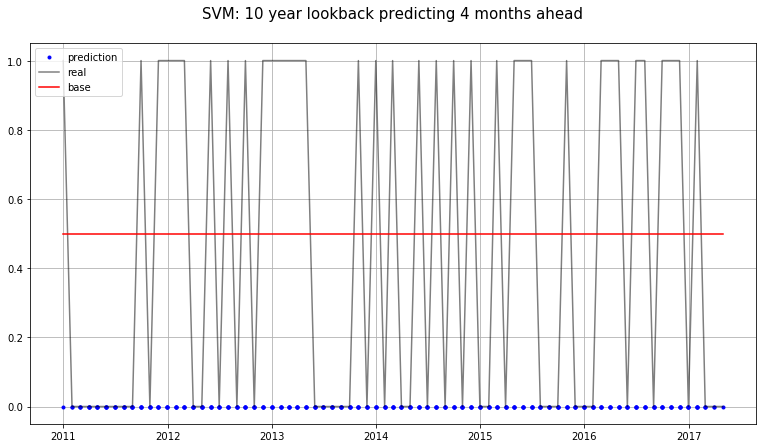

In [76]:
svm_png_dir = '/home/luke/workspace/Sector-Analysis/Luke_working_space/Plot generating codes/svm_png/'
start_index = clean_df.index.min()
plt.figure(figsize = (13,7))
plt.grid()
pred_1,pred_2,pred_3,pred_4,=plt.plot(clean_df,'b.')
real_y,=plt.plot(y.loc[start_index:,:],'k-',alpha = 0.5)
base,=plt.plot(clean_df.index,np.repeat(0.5,len(clean_df)),'r-')
plt.legend([pred_1,real_y,base],['prediction','real','base'],loc=2)
ttl = plt.title("SVM: 10 year lookback predicting 4 months ahead",fontsize = 15)
ttl.set_position([.5, 1.05])
plt.savefig(svm_png_dir+"svm_fit.png",bbox_inches='tight')
plt.show()